### Downloading the data

In [1]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


In [2]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [22]:
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
image_path_list = list(image_path.glob("*/*/*.jpg"))

def plot_random(path=image_path_list):
    random_image_path = random.choice(path)
    image_class = random_image_path.parent.stem
    img = Image.open(random_image_path)
    
    img_arr = np.array(img)
    plt.figure(figsize=(4,4))
    plt.imshow(img_arr)
    plt.title(f"Image class {image_class} \n Image shape {img_arr.shape}")
    plt.axis(False)

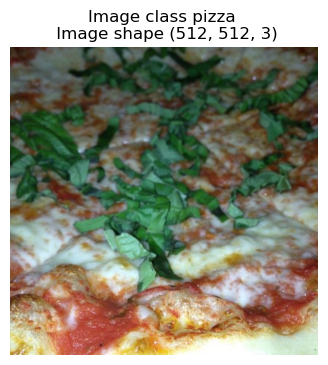

In [23]:
plot_random()

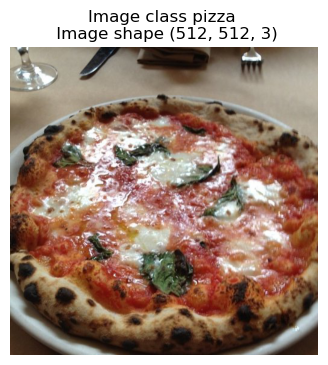

In [24]:
plot_random()

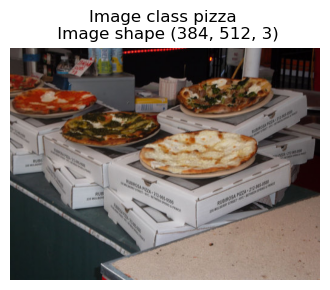

In [25]:
plot_random()

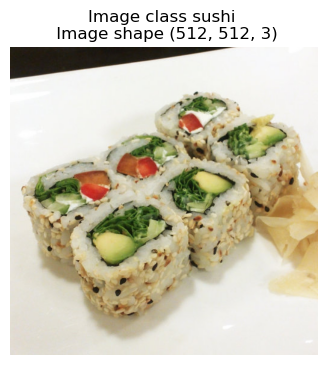

In [26]:
plot_random()

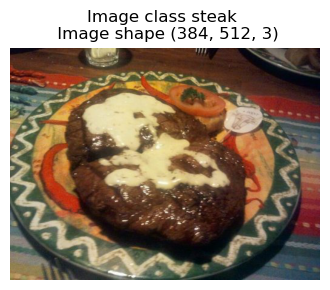

In [27]:
plot_random()

#### Transformations

In [28]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [30]:
# Write transform for image
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [77]:
def plot_transformations(image_paths,transform,n=6,seed=42):
    random.seed(seed)
    random_image_path = random.sample(image_paths,k=n)
    for image_path in random_image_path:
        image_class = image_path.parent.stem
        img = Image.open(image_path)
        img_arr = np.array(img)
        
        fig, ax = plt.subplots(1, 2)
        plt.figure(figsize=(4,4))
        ax[0].imshow(img_arr) 
        ax[0].set_title(f"Original \nSize: {img_arr.shape}")
        ax[0].axis("off")

        transformed_image = transform(img).permute(1,2,0)
        ax[1].imshow(transformed_image) 
        ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
        ax[1].axis("off")

        fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)
         
    

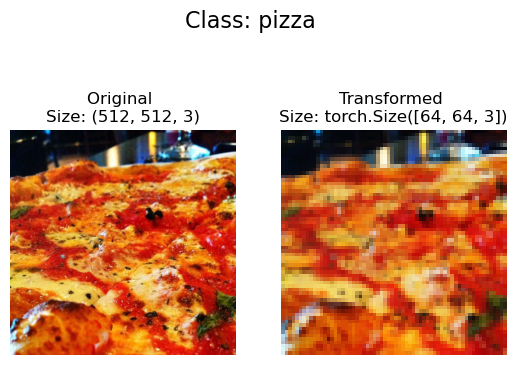

<Figure size 400x400 with 0 Axes>

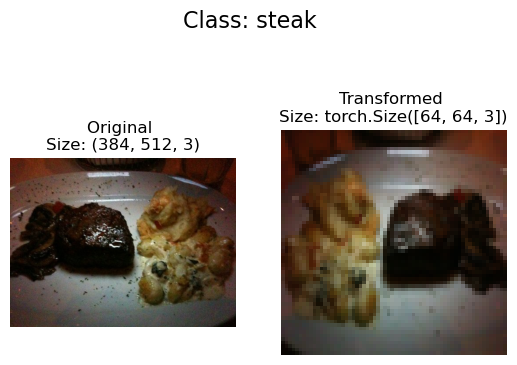

<Figure size 400x400 with 0 Axes>

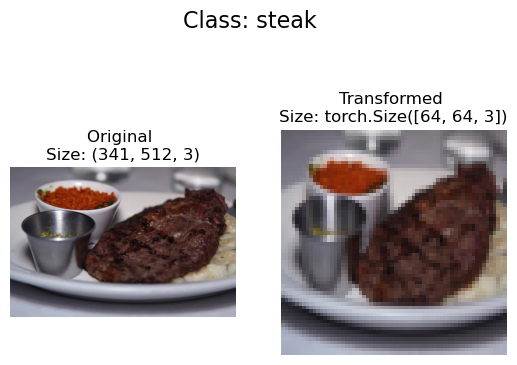

<Figure size 400x400 with 0 Axes>

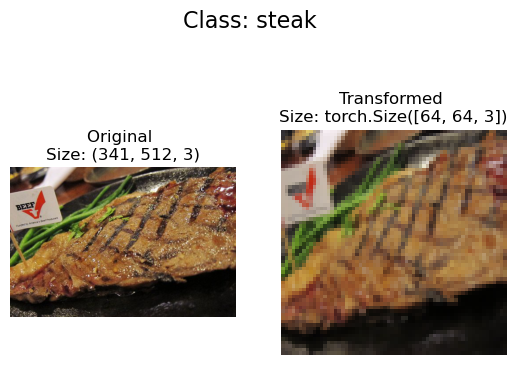

<Figure size 400x400 with 0 Axes>

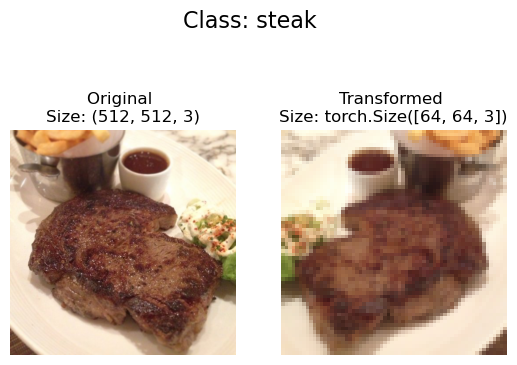

<Figure size 400x400 with 0 Axes>

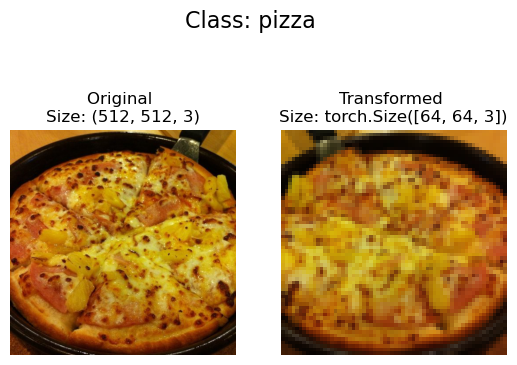

<Figure size 400x400 with 0 Axes>

In [80]:
plot_transformations(image_path_list,data_transform)

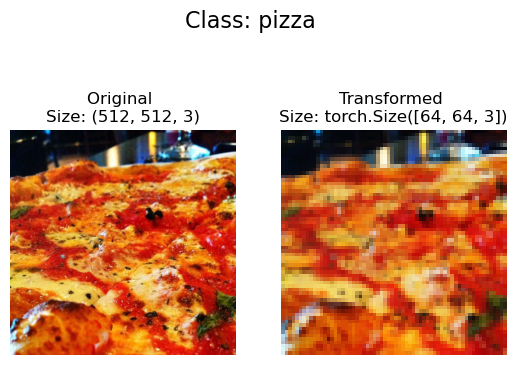

<Figure size 400x400 with 0 Axes>

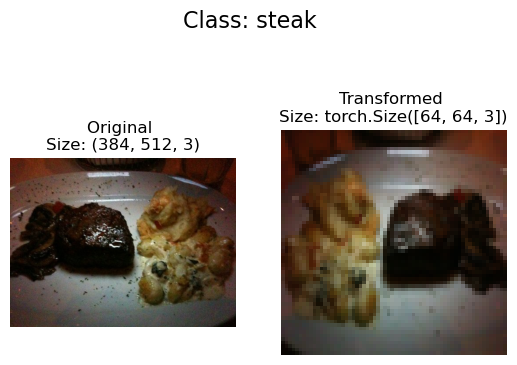

<Figure size 400x400 with 0 Axes>

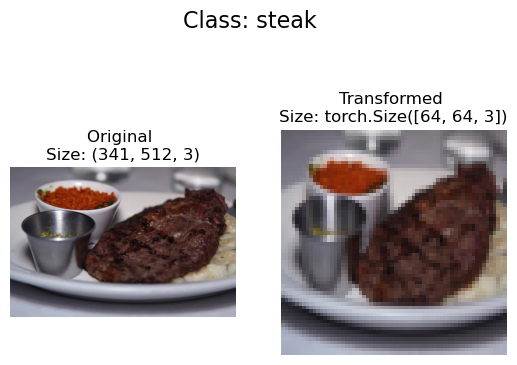

<Figure size 400x400 with 0 Axes>

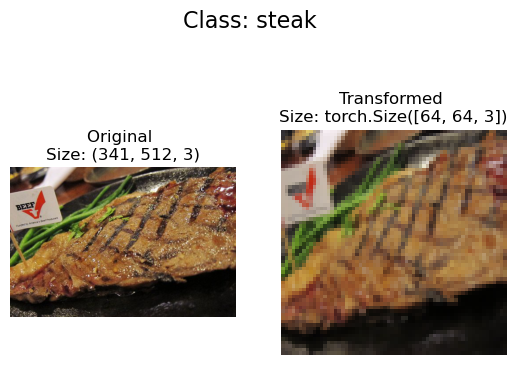

<Figure size 400x400 with 0 Axes>

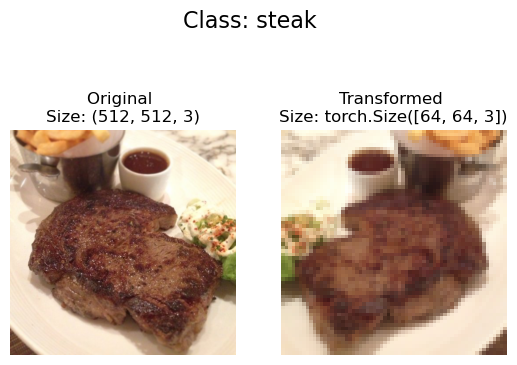

<Figure size 400x400 with 0 Axes>

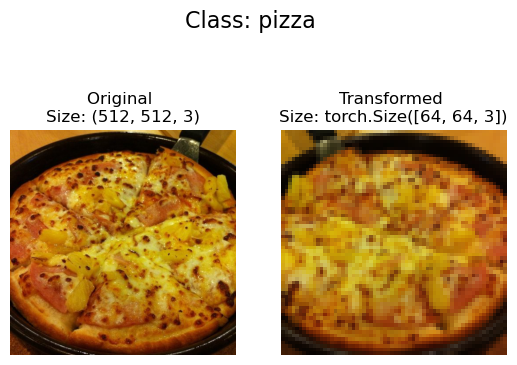

<Figure size 400x400 with 0 Axes>

In [80]:
plot_transformations(image_path_list,data_transform)